In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#pip install tflearn

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import random
import string
from nltk.stem.lancaster import LancasterStemmer
import tflearn
import tensorflow
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Instructions for updating:
non-resource variables are not supported in the long term


# **PART 1**

### **build a NLP classifier which can use input text parameters to determine the label/s of of the blog.**

### **1. Import and analyse the data set.**

In [4]:
Path = '/content/drive/MyDrive/Dataset/NLP assg/Dataset - blogtext.csv'
blogs = pd.read_csv(Path)

In [5]:
blogs.head(5)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [6]:
print(blogs.shape)

(681284, 7)


In [7]:
blogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [8]:
blogs.describe(include='all')

,id,gender,age,topic,sign,date,text
count,6.812840e+05,681284,681284.000000,681284,681284,681284,681284
unique,NaN,2,NaN,40,12,2616,611652
top,NaN,male,NaN,indUnk,Cancer,"02,August,2004",urlLink
freq,NaN,345193,NaN,251015,65048,16544,445
mean,2.397802e+06,NaN,23.932326,NaN,NaN,NaN,NaN
std,1.247723e+06,NaN,7.786009,NaN,NaN,NaN,NaN
min,5.114000e+03,NaN,13.000000,NaN,NaN,NaN,NaN
25%,1.239610e+06,NaN,17.000000,NaN,NaN,NaN,NaN
50%,2.607577e+06,NaN,24.000000,NaN,NaN,NaN,NaN
75%,3.525660e+06,NaN,26.000000,NaN,NaN,NaN,NaN


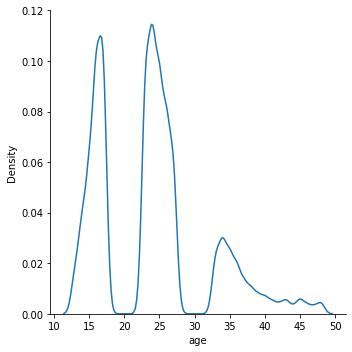

In [9]:
sns.displot(blogs, x='age',kind="kde")

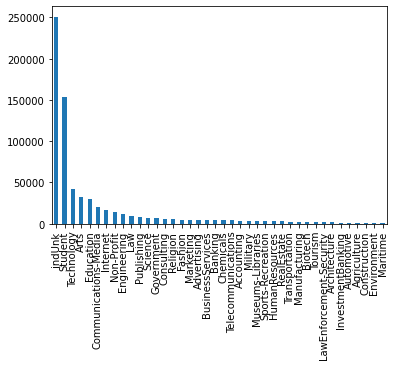

In [10]:
blogs['topic'].value_counts().plot(kind='bar')

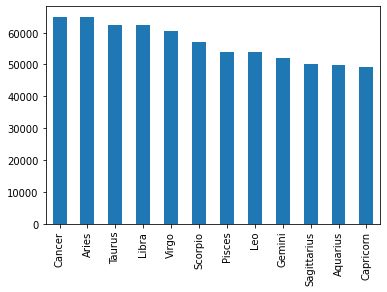

In [11]:
blogs['sign'].value_counts().plot(kind='bar')

In [12]:
blogs.gender.value_counts()

male      345193
female    336091
Name: gender, dtype: int64

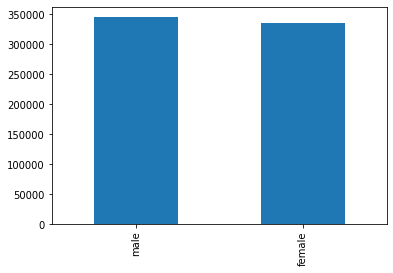

In [13]:
blogs['gender'].value_counts().plot(kind='bar')

### **2. Perform data pre-processing on the data:**

**a) Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.**

In [14]:
blogs['lower_text']=blogs['text'].astype('str').apply(lambda x: x.lower())

In [15]:
blogs.head(5)

,id,gender,age,topic,sign,date,text,lower_text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can ...


In [16]:
blogs['clean_t'] = blogs['lower_text'].replace('[^\w\s]','',regex=True)

In [17]:
blogs.head(5)

,id,gender,age,topic,sign,date,text,lower_text,clean_t
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages,...",info has been found 100 pages and ...
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewe...,these are the team members drewes...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!,testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can ...,thanks to yahoos toolbar i can no...


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop = set(stopwords.words('english'))

In [20]:
blogs['clean_text'] = blogs['clean_t'].apply(lambda words: " ".join (word for word in words.split() if word not in stop))

In [21]:
blogs.sample(5)

,id,gender,age,topic,sign,date,text,lower_text,clean_t,clean_text
399918,3040326,female,26,Publishing,Sagittarius,"15,June,2004",3AM Event Notice A Riot Of Our Own...,3am event notice a riot of our own...,3am event notice a riot of our own...,3am event notice riot 3am summer shindig liter...
190995,3416026,female,26,Student,Libra,"30,June,2004",I thought that once you left tenth grad...,i thought that once you left tenth grad...,i thought that once you left tenth grad...,thought left tenth grade officially allowed ou...
184587,2258198,male,25,Engineering,Gemini,"24,May,2004",So I've been reading urlLink Pen...,so i've been reading urllink pen...,so ive been reading urllink penn...,ive reading urllink penny arcade regular basis...
536664,1936076,male,24,indUnk,Virgo,"17,December,2003",FOR ALL THE GEEKS All y...,for all the geeks all y...,for all the geeks all y...,geeks geeks know probably familiar techtv dont...
527931,955372,female,16,Student,Aries,"14,November,2002",urlLink What Kind of Virgin Are Yo...,urllink what kind of virgin are yo...,urllink what kind of virgin are yo...,urllink kind virgin brought urllink quizilla


**b) Target/label merger and transformation**

In [22]:
blogs["age"] = blogs["age"].astype(str)
blogs["labels"] = blogs.apply(lambda col :
                            [col["gender"],col["age"],col["topic"],col["sign"]],axis =1)

In [23]:
blogs.head(5)

,id,gender,age,topic,sign,date,text,lower_text,clean_t,clean_text,labels
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages,...",info has been found 100 pages and ...,info found 100 pages 45 mb pdf files wait unti...,"[male, 15, Student, Leo]"
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewe...,these are the team members drewes...,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!,testing testing,testing testing,"[male, 15, Student, Leo]"
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can ...,thanks to yahoos toolbar i can no...,thanks yahoos toolbar capture urls popupswhich...,"[male, 33, InvestmentBanking, Aquarius]"


In [24]:
df = blogs[['clean_text','labels']]

In [25]:
df.head(5)

,clean_text,labels
0,info found 100 pages 45 mb pdf files wait unti...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoos toolbar capture urls popupswhich...,"[male, 33, InvestmentBanking, Aquarius]"


 **c) Train test split**

In [26]:
X = df.clean_text
y = df.labels

X_train, X_test, y_train, y_test =train_test_split(X,y, random_state=4,test_size = 0.2,shuffle = True)

In [27]:
print("shape of training set :", X_train.shape)
print("shape of test set :", X_test.shape)

shape of training set : (545027,)
shape of test set : (136257,)


 **d) Vectorisation**

**tf-idf vectorizer**

In [28]:
tfidf = TfidfVectorizer()
tfidf.fit(list(X_train) + list(X_test))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
X_train_tfv =  tfidf.transform(X_train) 
X_test_tfv = tfidf.transform(X_test)

 **Target/label transformation**

In [30]:
label_count=dict()

for labels in df.labels.values:
    for label in labels:
        if label in label_count:
            label_count[str(label)]+=1
        else:
            label_count[str(label)]=1
        
label_count

{'13': 13133,
 '14': 27400,
 '15': 41767,
 '16': 72708,
 '17': 80859,
 '23': 72889,
 '24': 80071,
 '25': 67051,
 '26': 55312,
 '27': 46124,
 '33': 17584,
 '34': 21347,
 '35': 17462,
 '36': 14229,
 '37': 9317,
 '38': 7545,
 '39': 5556,
 '40': 5016,
 '41': 3738,
 '42': 2908,
 '43': 4230,
 '44': 2044,
 '45': 4482,
 '46': 2733,
 '47': 2207,
 '48': 3572,
 'Accounting': 3832,
 'Advertising': 4676,
 'Agriculture': 1235,
 'Aquarius': 49687,
 'Architecture': 1638,
 'Aries': 64979,
 'Arts': 32449,
 'Automotive': 1244,
 'Banking': 4049,
 'Biotech': 2234,
 'BusinessServices': 4500,
 'Cancer': 65048,
 'Capricorn': 49201,
 'Chemicals': 3928,
 'Communications-Media': 20140,
 'Construction': 1093,
 'Consulting': 5862,
 'Education': 29633,
 'Engineering': 11653,
 'Environment': 592,
 'Fashion': 4851,
 'Gemini': 51985,
 'Government': 6907,
 'HumanResources': 3010,
 'Internet': 16006,
 'InvestmentBanking': 1292,
 'Law': 9040,
 'LawEnforcement-Security': 1878,
 'Leo': 53811,
 'Libra': 62363,
 'Manufacturi

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

MultiLabelBinarizer=MultiLabelBinarizer(classes=sorted(label_count.keys()))


y_train = MultiLabelBinarizer.fit_transform(y_train)
y_test = MultiLabelBinarizer.transform(y_test)

In [32]:
print('y_train',y_train)
print('y_test',y_test)

y_train [[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
y_test [[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


### **3. Design, train, tune and test the best text classifier.**

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

LogReg = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='saga'),n_jobs=-1))])

In [34]:
LogReg.fit(X_train_tfv, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                                                                  max_iter=100,
                                                                  multi_class='auto',
                                                                  n_jobs=None,
                                                                  penalty='l2',
                                                                  random_state=None,
                                                      

In [35]:
Y_pred = LogReg.predict(X_test_tfv)

In [36]:
print('Testing Accuracy score: ', accuracy_score(y_test, Y_pred))

Testing Accuracy score:  0.02245756181333803


### **4. Display and explain detail the classification report**

In [37]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      0.05      0.10      2677
           1       0.81      0.07      0.14      5504
           2       0.74      0.07      0.13      8347
           3       0.79      0.12      0.21     14714
           4       0.76      0.12      0.21     16262
           5       0.82      0.03      0.06     14668
           6       0.85      0.04      0.07     15869
           7       0.80      0.03      0.06     13422
           8       0.82      0.04      0.07     10954
           9       0.86      0.03      0.06      9301
          10       0.98      0.02      0.05      3545
          11       0.91      0.11      0.20      4157
          12       0.83      0.07      0.13      3529
          13       0.95      0.06      0.12      2809
          14       0.97      0.06      0.11      1764
          15       0.97      0.02      0.05      1449
          16       1.00      0.01      0.02      1097
          17       1.00    

#### **Observation:**
1. As per observation, model is giving low accuracy.
2. As recall means "how many of this class find over the whole number of element of this class", so as per above clssification report recall value is also very low for all the classes.
3. As per precision most of the classes are correctly classified. (most of the classes are above 0.80)


### **5. Print the true vs predicted labels for any 5 entries from the dataset.**

In [38]:
import random 

def print_prediction(Y_pred, y_test = y_test , n = 5):
    j = []
    for i in range(n):
        j.append(random.randint(0, len(y_test)))
    print(j)
                 
    for k in j:
        print(MultiLabelBinarizer.inverse_transform(Y_pred)[k])
        print(MultiLabelBinarizer.inverse_transform(y_test)[k])

In [39]:
print_prediction(Y_pred=Y_pred,y_test=y_test, n= 5)

[91686, 128589, 11245, 6290, 38279]
('female',)
('23', 'Virgo', 'indUnk', 'male')
('male',)
('26', 'Leo', 'Student', 'female')
('male',)
('24', 'Libra', 'Student', 'male')
('indUnk', 'male')
('23', 'Aquarius', 'female', 'indUnk')
('male',)
('15', 'Student', 'Taurus', 'male')


In [40]:
five_pred = Y_pred[:5]
five_actual = y_test[:5]

In [41]:
five_actual = MultiLabelBinarizer.inverse_transform(five_actual)
five_actual

[('34', 'Aries', 'indUnk', 'male'),
 ('17', 'Leo', 'indUnk', 'male'),
 ('24', 'Arts', 'Scorpio', 'female'),
 ('17', 'Aquarius', 'indUnk', 'male'),
 ('23', 'Aquarius', 'Technology', 'male')]

In [42]:
five_pred = MultiLabelBinarizer.inverse_transform(five_pred)
five_pred

[('male',),
 ('indUnk', 'male'),
 ('24', 'Arts', 'Sagittarius', 'female'),
 ('male',),
 ('male',)]

# **PART 2**

## **Design a python based interactive semi - rule based chatbot**

In [43]:
import json
FILE_PATH = '/content/drive/MyDrive/Dataset/NLP assg/GL Bot.json'
with open(FILE_PATH) as file:
    data = json.load(file)

In [44]:
words = []
labels = []
docs_x = []
docs_y = []

In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
for intent in data['intents']:
    for pattern in intent['patterns']:
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds)
        docs_x.append(wrds)
        docs_y.append(intent["tag"])
        
    if intent['tag'] not in labels:
        labels.append(intent['tag'])

**Stemming**

In [47]:
stemmer = LancasterStemmer()
words = [stemmer.stem(w.lower()) for w in words if w != "?"]
words = sorted(list(set(words)))

labels = sorted(labels)

In [48]:
training = []
output = []

out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
    bag = []

    wrds = [stemmer.stem(w.lower()) for w in doc]

    for w in words:
        if w in wrds:
            bag.append(1)
        else:
            bag.append(0)

    output_row = out_empty[:]
    output_row[labels.index(docs_y[x])] = 1

    training.append(bag)
    output.append(output_row)

In [49]:
training = np.array(training)
output = np.array(output)

In [50]:
print(training.shape)
print(output.shape)

(128, 150)
(128, 8)


In [51]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

net = tflearn.input_data(shape=[None, len(training[0])])
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, 8)
net = tflearn.fully_connected(net, len(output[0]), activation="softmax")
net = tflearn.regression(net)

model = tflearn.DNN(net)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [52]:
model.fit(training, output, n_epoch=100, batch_size=8, show_metric=True)

Training Step: 1599  | total loss: 0.26877 | time: 0.081s
| Adam | epoch: 100 | loss: 0.26877 - acc: 0.9989 -- iter: 120/128
Training Step: 1600  | total loss: 0.26365 | time: 0.089s
| Adam | epoch: 100 | loss: 0.26365 - acc: 0.9990 -- iter: 128/128
--


In [53]:
def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]

    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
            
    return np.array(bag)


def chat():
    print("Start talking with the bot (type quit to stop)!")
    while True:
        inp = input("You: ")
        if inp.lower() == "quit":
            break

        results = model.predict([bag_of_words(inp, words)])
        results_index = np.argmax(results)
        tag = labels[results_index]

        for tg in data["intents"]:
            if tg['tag'] == tag:
                responses = tg['responses']

        print(random.choice(responses))

In [54]:
chat()

Start talking with the bot (type quit to stop)!
You: hi
Hello! how can i help you ?
You: whom to contact for olympus
Link: Olympus wiki
You: i am not able to understand ada boosting
Link: Machine Learning wiki 
You: i am not able to understand deep learning"
Link: Neural Nets wiki
You: EPOChs
Link: Neural Nets wiki
You: name please
I am your virtual learning assistant
You: you r stupid
Please use respectful words
You: my problem is not solved
Tarnsferring the request to your PM
You: you are a good learning buddy
I hope I was able to assist you, Good Bye
You: quit
